# SIS Health Vector

Eignung für das Vorkommen und die saisonale Aktivität der Tigermücke (Aedes albopictus) in Europa

Dieses Skript verarbeitet den Datensatz **SIS Health Vector** aus dem Copernics Climate Data Store. Der Datensatz enthält Informationen zu der Eignung der Umweltbedingungen sowie der saisonalen Aktivität der Tigermücke. Der Datensatz wurde im Rahmen des C3S European Health Service entwickelt. Die Informationen sind für unterschiedliche zukünftige Zeiträume und Klimawandelszenarien verfügbar.

**Informationen zum Datensatz**: 

* Source: [SIS Health Vector](https://cds.climate.copernicus.eu/datasets/sis-health-vector?tab=overview)
* Author: T. Tewes (Stadt Konstanz) 
* Resolution: 0.1° x 0.1°
* Notebook-Version: 1.1 (Updated: December 02, 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Hier die Verzeichnisse angeben ---- '''
download_folder = r".\data\sis-health-vector\download"
working_folder = r".\data\sis-health-vector\working"
geotiff_folder = r".\data\sis-health-vector\geotiff"
csv_folder = r".\data\sis-health-vector\csv"
output_folder = r".\data\sis-health-vector\output"
''' ----- Ende der Eingaben ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract Dataset

### 2.1 API Authentication

In [2]:
import cdsapi

def main():
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Request Definition and Download

In [3]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0] # North, West, South, East
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]

# Alternatively, use a shapefile for precise geographic filtering
import geopandas as gpd
import math

# Example: Load shapefile of Konstanz (WGS84 projection)
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)
de_bounds = de_gdf.total_bounds

# Adjust and buffer
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [4]:
dataset = "sis-health-vector"
request = {
    "variable": [
        "suitability",
        "season_length"
    ],
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_statistic": [
        "ensemble_members_average",
        "ensemble_members_standard_deviation"
    ],
    "area": bbox_de_bounds_adjusted
}

In [5]:
# Run this cell to download the dataset:

def main_retrieve():
    dataset_filename = f"{dataset}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    client = main()
    main_retrieve()

2025-02-11 09:25:00,585 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-02-11 09:25:00,587 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


Dataset already downloaded.


### 2.3 Extract the Zip folder

In [6]:
import zipfile

dataset_filename = f"{dataset}.zip"
dataset_filepath = os.path.join(download_folder, dataset_filename)

# Extract the zip file
try:
    os.makedirs(working_folder, exist_ok=True)
    
    if not os.listdir(working_folder):
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(working_folder)
            print(f"Successfully extracted files to: {working_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Read the netCDF file and print the metadata

In [7]:
import re
import pandas as pd

def meta(filename):
    match = re.search(r'mosquito_(suit|seas)_(rcp\d{2})_(\w+)_v(\d+\.\d+)\.', filename)
    if not match:
        raise ValueError("the given filename does not fit the expected naming scheme")
    
    var = match.group(1)
    return dict(
        filename=filename,
        path=os.path.join(working_folder, filename),
        variable=var,
        variable_name="season_length" if var == 'seas' else "suitability",
        rcp = match.group(2),
        statistic = match.group(3),
        version = match.group(4),
    )

# Create DataFrame from the list of files inside the extracted directory
nc_files = [meta(f) for f in os.listdir(working_folder) if f.endswith('.nc')]
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Modify pandas display options
pd.options.display.max_colwidth = 30

# Display the DataFrame
df_nc_files.head().loc[:, df_nc_files.columns != 'path']

,filename,variable,variable_name,rcp,statistic,version
0,mosquito_seas_rcp45_mean_v...,seas,season_length,rcp45,mean,1.0
1,mosquito_seas_rcp45_stdev_...,seas,season_length,rcp45,stdev,1.0
2,mosquito_seas_rcp85_mean_v...,seas,season_length,rcp85,mean,1.0
3,mosquito_seas_rcp85_stdev_...,seas,season_length,rcp85,stdev,1.0
4,mosquito_suit_rcp45_mean_v...,suit,suitability,rcp45,mean,1.0


In [8]:
import netCDF4 as nc

seen_variables = set()

for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable']
    
    if variable_name in seen_variables:
        continue

    # Open the NetCDF file in read mode
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')

    # List all variables in the dataset
    variables_list = nc_dataset.variables.keys()
    print(f"{i+1}. {variable_name}: Available variables: {list(variables_list)}")
    
    # Add the variable name to the seen set
    seen_variables.add(variable_name)

1. seas: Available variables: ['season_length', 'height', 'lat', 'lon', 'time']
5. suit: Available variables: ['suitability', 'height', 'lat', 'lon', 'time']


In [9]:
seen_variables = set()

for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    if variable_name in seen_variables:
        continue
    
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')
    variable_data = nc_dataset[variable_name]
    
    # Generate summary of the primary variable
    summary = {
        "Variable Name": variable_name,
        "Data Type": variable_data.dtype,
        "Shape": variable_data.shape,
        "Variable Info": f"{variable_name}({', '.join(variable_data.dimensions)})",
        "Units": getattr(variable_data, "units", "N/A"),
        "Long Name": getattr(variable_data, "long_name", "N/A"),
    }
    
    # Display dataset summary as a DataFrame for better visualization
    nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])

    # Display the summary DataFrame
    print(f"{i+1}. {nc_file['variable']}:")
    display(nc_summary)
    
    # Add the variable name to the seen set
    seen_variables.add(variable_name)

1. seas:


,Description,Remarks
0,Variable Name,season_length
1,Data Type,float32
2,Shape,"(100, 82, 95)"
3,Variable Info,"season_length(time, lat, lon)"
4,Units,1
5,Long Name,Ensemble members average o...


5. suit:


,Description,Remarks
0,Variable Name,suitability
1,Data Type,float32
2,Shape,"(100, 82, 95)"
3,Variable Info,"suitability(time, lat, lon)"
4,Units,1
5,Long Name,Ensemble members average o...


## 4. Export Dataset to CSV

In [10]:
import numpy as np
import netCDF4 as nc

def netcdf_to_dataframe(
    nc_file,
    bounding_box=None):
    """
    Converts a netCDF file to a DataFrame, optionally filtering by a bounding box.

    Parameters:
        nc_file (dict): Dictionary with keys 'filename', 'path', 'variable', 'variable_name', 'rcp', 'statistic', 'version'.
        bbox (list): Bounding box as [lon_min, lat_min, lon_max, lat_max] (optional).

    Returns:
        pd.DataFrame: DataFrame with time, latitude, longitude, and the variable's values.
    """
    try:
        # Open the netCDF file
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
        
        # Retrieve the variable name
        variable = nc_file['variable']
        if variable == 'suit':
            variable_name = 'suitability'
        elif variable == 'seas':
            variable_name = 'season_length'
        else:
            raise ValueError(f"Unexpected variable: {variable}")
        
        # Extract time variable and convert it to readable dates
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)

        # Extract temperature/variable data
        variable_data = nc_dataset.variables[variable_name][:]
        
        # Filter by bounding box if provided
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
            
            filtered_lat = lat[start_lat:end_lat]
            filtered_lon = lon[start_lon:end_lon]
            variable_data_subset = variable_data[:, start_lat:end_lat, start_lon:end_lon]
        else:
            filtered_lat = lat
            filtered_lon = lon
            variable_data_subset = variable_data
            
        # Create a column name for the variable
        variable_column_name = f"{variable}-{nc_file['rcp']}-{nc_file['statistic']}"
        
        
        # Create rows for the DataFrame
        rows = []
        for t in range(variable_data_subset.shape[0]):
            for i in range(variable_data_subset.shape[1]):
                for j in range(variable_data_subset.shape[2]):
                    if not np.ma.is_masked(variable_data_subset[t, i, j]):
                        rows.append({
                            'time': cftime[t],
                            'latitude': filtered_lat[i],
                            'longitude': filtered_lon[j],
                            variable_column_name: variable_data_subset[t, i, j]
                        })
                    
        # Create a DataFrame from the rows
        df = pd.DataFrame(rows)
        df['time'] = pd.to_datetime(df['time'].map(str))
        df['latitude'] = pd.to_numeric(df['latitude'])
        df['longitude'] = pd.to_numeric(df['longitude'])
        df[variable_column_name] = pd.to_numeric(df[variable_column_name])
        
        # Set the index to time, latitude, and longitude
        return df.set_index(['time', 'latitude', 'longitude'])
    except KeyError as e:
        raise ValueError(f"KeyError: Missing required variable in the netCDF file: {e}")
    finally:
        # Ensure the dataset is closed
        nc_dataset.close()

### 4.1 Create Individual DataFrame and Export as Individual CSV files

In [11]:
# Create individual DataFrame and Export as individual CSV files
for nc_file in nc_files:
    csv_filename = f"mosquito_{nc_file['variable']}_{nc_file['rcp']}_{nc_file['statistic']}.csv"
    csv_path = os.path.join(csv_folder, csv_filename)
    
    if not os.path.isfile(csv_path):
        df = netcdf_to_dataframe(nc_file, bounding_box=None)
        df.to_csv(csv_path)
        print(f"Data exported successfully to {csv_path}")
    else:
        print(f"File already exists at {csv_path}. Skipping export.")
        df = pd.read_csv(csv_path).set_index(['time', 'latitude', 'longitude'])
        
# Modify display format for numbers in the DataFrames
pd.options.display.float_format = '{:,.2f}'.format

# Display DataFrame
df

File already exists at .\data\sis-health-vector\csv\mosquito_seas_rcp45_mean.csv. Skipping export.


File already exists at .\data\sis-health-vector\csv\mosquito_seas_rcp45_stdev.csv. Skipping export.


File already exists at .\data\sis-health-vector\csv\mosquito_seas_rcp85_mean.csv. Skipping export.


File already exists at .\data\sis-health-vector\csv\mosquito_seas_rcp85_stdev.csv. Skipping export.


File already exists at .\data\sis-health-vector\csv\mosquito_suit_rcp45_mean.csv. Skipping export.
File already exists at .\data\sis-health-vector\csv\mosquito_suit_rcp45_stdev.csv. Skipping export.


File already exists at .\data\sis-health-vector\csv\mosquito_suit_rcp85_mean.csv. Skipping export.


File already exists at .\data\sis-health-vector\csv\mosquito_suit_rcp85_stdev.csv. Skipping export.


suit-rcp85-stdev
time       latitude longitude                  
1986-01-01 47.10    5.70                   2.63
                    5.80                   3.02
                    5.90                   3.11
                    6.00                   3.57
                    6.10                   3.53
...                                         ...
2085-01-01 55.20    14.70                  9.20
                    14.80                  9.65
                    14.90                  8.25
                    15.00                  7.34
                    15.10                  6.53

[729100 rows x 1 columns]

### 4.2 Create DataFrame and Export as merged CSV file

In [12]:
from tqdm.notebook import tqdm

csv_filename = 'sis-health-vector-merged.csv.zip'
csv_path = os.path.join(csv_folder, csv_filename)

if not os.path.isfile(csv_path):
    dataframes = [netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files)]
    df_merged = pd.concat(dataframes, axis=1)
    df_merged.to_csv(csv_path, sep=',', encoding='utf8', compression='zip')
else:
    print(f"File already exists at {csv_path}. Skipping export.")
    print("Reading existing CSV file...")
    df_merged = pd.read_csv(csv_path).set_index(['time', 'latitude', 'longitude'])
    
# Display DataFrame
df_merged

File already exists at .\data\sis-health-vector\csv\sis-health-vector-merged.csv.zip. Skipping export.
Reading existing CSV file...


seas-rcp45-mean  seas-rcp45-stdev  \
time       latitude longitude                                      
1986-01-01 47.10    5.70                137.85              8.88   
                    5.80                134.25              7.83   
                    5.90                127.43             10.29   
                    6.00                118.44             13.42   
                    6.10                103.06             13.96   
...                                        ...               ...   
2085-01-01 55.20    14.70               102.34             20.69   
                    14.80                94.36             22.07   
                    14.90                91.52             21.24   
                    15.00                94.66             19.00   
                    15.10               104.35             17.06   

                               seas-rcp85-mean  seas-rcp85-stdev  \
time       latitude longitude                                      
1986-01-01 47.10    5.70                137.85              8.32   
                    5.80                134.25              8.09   
                    5.90                127.43              9.92   
                    6.00                118.44             11.70   
                    6.10                103.06             12.18   
...                                        ...               ...   
2085-01-01 55.20    14.70               135.23             18.08   
                    14.80               131.20             20.02   
                    14.90               128.82             20.77   
                    15.00               129.81             19.47   
                    15.10               138.60             14.97   

                               suit-rcp45-mean  suit-rcp45-stdev  \
time       latitude longitude                                      
1986-01-01 47.10    5.70                 83.47              2.55   
                    5.80                 80.93              2.91   
                    5.90                 76.16              3.28   
                    6.00                 69.44              3.90   
                    6.10                 61.91              3.89   
...                                        ...               ...   
2085-01-01 55.20    14.70                66.27             10.68   
                    14.80                63.85             10.38   
                    14.90                63.01              8.24   
                    15.00                65.55              7.65   
                    15.10                68.65              7.68   

                               suit-rcp85-mean  suit-rcp85-stdev  
time       latitude longitude                                     
1986-01-01 47.10    5.70                 83.47              2.63  
                    5.80                 80.93              3.02  
                    5.90                 76.16              3.11  
                    6.00                 69.44              3.57  
                    6.10                 61.91              3.53  
...                                        ...               ...  
2085-01-01 55.20    14.70                83.59              9.20  
                    14.80                81.74              9.65  
                    14.90                81.60              8.25  
                    15.00                83.25              7.34  
                    15.10                85.24              6.53  

[779000 rows x 8 columns]

### 4.2 Filter by Area, Create DataFrame and Export as merged CSV file

In [13]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

# Bounding box for the Konstanz region (WGS84 projection):
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]  # Format: [North, West, South, East]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # Standard format: [West, South, East, North]

csv_filename = "sis-health-vector-merged-subset.csv.zip"
csv_path = os.path.join(csv_folder, csv_filename)

if not os.path.isfile(csv_path):
    dataframes = [netcdf_to_dataframe(nc_file, bounding_box=bbox_wgs84_konstanz_standard) for nc_file in tqdm(nc_files)]
    df_merged_subset = pd.concat(dataframes, axis=1)
    df_merged_subset.to_csv(csv_path, sep=',', encoding='utf8', compression='zip')
else:
    print(f"File already exists at {csv_path}. Skipping export.")
    df_merged_subset = pd.read_csv(csv_path).set_index(['time', 'latitude', 'longitude'])
    
# Display DataFrame
df_merged_subset

File already exists at .\data\sis-health-vector\csv\sis-health-vector-merged-subset.csv.zip. Skipping export.


seas-rcp45-mean  seas-rcp45-stdev  \
time       latitude longitude                                      
1986-01-01 47.60    9.00                106.96             12.80   
                    9.10                109.16             12.32   
                    9.20                111.20             12.67   
           47.70    9.00                105.13             12.74   
                    9.10                105.82             13.31   
...                                        ...               ...   
2085-01-01 47.70    9.10                158.96              8.82   
                    9.20                159.18              8.65   
           47.80    9.00                155.63             11.82   
                    9.10                155.20             11.29   
                    9.20                154.19             11.30   

                               seas-rcp85-mean  seas-rcp85-stdev  \
time       latitude longitude                                      
1986-01-01 47.60    9.00                106.96             10.82   
                    9.10                109.16             10.61   
                    9.20                111.20             11.31   
           47.70    9.00                105.13              9.80   
                    9.10                105.82             10.28   
...                                        ...               ...   
2085-01-01 47.70    9.10                169.36              8.41   
                    9.20                169.73              8.56   
           47.80    9.00                168.53              8.90   
                    9.10                166.86              9.72   
                    9.20                166.15             10.07   

                               suit-rcp45-mean  suit-rcp45-stdev  \
time       latitude longitude                                      
1986-01-01 47.60    9.00                 74.46              3.40   
                    9.10                 76.52              2.88   
                    9.20                 77.60              2.58   
           47.70    9.00                 72.90              3.08   
                    9.10                 75.07              2.67   
...                                        ...               ...   
2085-01-01 47.70    9.10                 92.85              2.52   
                    9.20                 93.56              2.37   
           47.80    9.00                 91.11              3.42   
                    9.10                 91.48              3.20   
                    9.20                 91.22              3.22   

                               suit-rcp85-mean  suit-rcp85-stdev  
time       latitude longitude                                     
1986-01-01 47.60    9.00                 74.46              3.24  
                    9.10                 76.52              2.79  
                    9.20                 77.60              2.49  
           47.70    9.00                 72.90              2.89  
                    9.10                 75.07              2.55  
...                                        ...               ...  
2085-01-01 47.70    9.10                 93.04              5.05  
                    9.20                 93.12              5.05  
           47.80    9.00                 95.61              2.51  
                    9.10                 95.51              2.61  
                    9.20                 95.47              2.75  

[900 rows x 8 columns]

## 5. Export Dataset to GeoTIFF

### 5.1 Function to export the Dataset as GeoTIFF File(s)

In [14]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Export the entire multi-year dataset or a specified range as a single merged GeoTIFF file.

    Parameters:
        nc_file (dict): A dictionary with keys 'path' (file path), 'variable', 'rcp', and 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
        merged (bool): Whether to generate merged GeoTIFF or individual GeoTIFFs (optional).
        output_directory (str): Directory to save the output GeoTIFF files (optional).
    """
    
    # Open the netCDF file
    nc_dataset = nc.Dataset(nc_file['path'], 'r')
    lon = nc_dataset['lon'][:]
    lat = nc_dataset['lat'][:]
    
    # Retrieve the variable name
    variable = nc_file['variable']
    if variable == 'suit':
        variable_name = 'suitability'
    elif variable == 'seas':
        variable_name = 'season_length'
    else:
        raise ValueError(f"Unexpected variable: {variable}")
            
    # Extract temperature/variable data
    variable_data = nc_dataset.variables[variable_name][:]
    
            # Filter by bounding box if provided
    if bounding_box:
        lon_min, lat_min, lon_max, lat_max = bounding_box
        
        indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
        indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
        start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
        start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
    else:
        start_lat, end_lat = 0, len(lat)
        start_lon, end_lon = 0, len(lon)
    
    lat = lat[start_lat:end_lat]
    lon = lon[start_lon:end_lon]
        
    # Extract time variable and convert it to readable dates
    time_var = nc_dataset.variables['time']
    time_units = time_var.units
    time_calendar = getattr(time_var, "calendar", "standard")
    cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
    
    # Compute spatial resolution and raster transformation
    dx = abs(lon[1] - lon[0])
    dy = abs(lat[1] - lat[0])
    transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
        
    # Determine the time range
    min_year = cftime[0].year
    max_year = cftime[-1].year

    if start_year and end_year:
        # Adjust start_year and end_year based on the available cftime range
        if start_year < min_year:
            print(f"Provided start year {start_year} is earlier than the dataset range. Adjusting start year to {min_year}.")
        if end_year > max_year:
            print(f"Provided end year {end_year} is later than the dataset range. Adjusting end year to {max_year}.")
        start_year = max(start_year, min_year)
        end_year = min(end_year, max_year)

        dt_full_start = start_year
        dt_full_end = end_year
    else:
        # Default to the full dataset
        dt_full_start = min_year
        dt_full_end = max_year
        start_year = min_year
        end_year = max_year
        
    # Find indices corresponding to the specified year range
    start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
    end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1 # Year
    
    variable_data = nc_dataset[variable_name]
    variable_data_subset = variable_data[start_index:end_index,
                                         start_lat:end_lat,
                                         start_lon:end_lon]
    
    # Create subset directory name based on the nc_file
    nc_filename = f"mosquito_{nc_file['variable']}_{nc_file['rcp']}_{nc_file['statistic']}"
    
    if merged:
        # Create a merged GeoTIFF containing all time slices as separate bands
        if output_directory:
            subset_directory_path = output_directory
        else:
            subset_directory_path = os.path.join(geotiff_folder, f"{nc_filename}-merged")
            os.makedirs(subset_directory_path, exist_ok=True)
        
        output_filename = f"{nc_filename}-merged-{dt_full_start}-{dt_full_end}.tif"
        output_filepath = os.path.join(subset_directory_path, output_filename)

        # Create a GeoTIFF with multiple bands for each time slice
        with rasterio.open(
            output_filepath,
            "w",
            driver = "GTiff",
            dtype = str(variable_data_subset.dtype),
            width = variable_data_subset.shape[2],
            height = variable_data_subset.shape[1],
            count = variable_data_subset.shape[0],
            crs = "EPSG:4326",
            nodata = -9999,
            transform=transform,        
        ) as dst:
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                   desc=f"Exporting merged GeoTIFF file from {start_year} to {end_year}"):
                band_data = variable_data_subset[year_index,:,:]
                dt = cftime[start_index + year_index]
                band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                
                # Write each year slice as a band
                dst.write(band_data, year_index + 1)
                dst.set_band_description(year_index + 1, band_desc)

    else:
        if output_directory:
            subset_directory_path = output_directory
        else:
            subset_directory_path = os.path.join(geotiff_folder, f"{nc_filename}-individual")
            os.makedirs(subset_directory_path, exist_ok=True)
        
        for year_index in tqdm(range(variable_data_subset.shape[0]),
                               desc="Exporting individual GeoTIFF files"):
            # Retrieve the date for the current time slice
            dt = cftime[start_index + year_index]
            dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

            # Define the output GeoTIFF file path            
            output_filename = f"{nc_filename}_{dt_full}.tif"
            output_filepath = os.path.join(subset_directory_path, output_filename)

            # Export the current time slice as a GeoTIFF
            with rasterio.open(
                output_filepath,
                "w",
                driver="GTiff",
                dtype=str(variable_data_subset.dtype),
                width=variable_data_subset.shape[2],
                height=variable_data_subset.shape[1],
                count=1,
                crs="EPSG:4326",
                nodata=-9999,
                transform=transform,
            ) as dst:
                year_precipitation_data = variable_data_subset[year_index, :, :]
                dst.write(year_precipitation_data, 1)
                dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")
            
    # Ensure the dataset is closed
    nc_dataset.close()


### 5.2 Export selected dataset to GeoTIFF

In [15]:
# Specify the year range to filter and combine data into a single GeoTIFF.
# If no range is provided, the full dataset will be used.
# If same start and end year is used for export, then old GeoTIFF file will be replaced.

if __name__ == "__main__":
    # First file = mosquito_seas_rcp45_mean_v1.0
    main_export_geotiff(nc_file=nc_files[0],
                        bounding_box=None,
                        merged=True)
    
    main_export_geotiff(nc_file=nc_files[0],
                        bounding_box=None,
                        merged=False)
    
    # Export all merged and individual
    for nc_file in nc_files:
        main_export_geotiff(nc_file=nc_file,
                            bounding_box=None,
                            merged=True)
        main_export_geotiff(nc_file=nc_file,
                            bounding_box=None,
                            merged=False)
            
    # Additional case (Advanced filtering)
    temp_folder = os.path.join(geotiff_folder, "temp_folder")
    os.makedirs(temp_folder, exist_ok=True)
    
    main_export_geotiff(nc_file=nc_file,
                        bounding_box=bbox_wgs84_konstanz_standard,
                        start_year=2000,
                        end_year=2020,
                        merged=True,
                        output_directory=temp_folder)

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 2000 to 2020:   0%|          | 0/21 [00:00<?, ?it/s]

## 6. Plot using Matplotlib

In [16]:
import matplotlib.pyplot as plt

lon_min, lat_min, lon_max, lat_max = bbox_wgs84_konstanz_standard

# Filter the dataframe with query
filtered_df = (
    df_merged.query(
        "@lat_min <= latitude <= @lat_max and @lon_min <= longitude <= @lon_max"
    )
    .reset_index()
    .set_index("time")
)

filtered_df.head()

,latitude,longitude,seas-rcp45-mean,seas-rcp45-stdev,seas-rcp85-mean,seas-rcp85-stdev,suit-rcp45-mean,suit-rcp45-stdev,suit-rcp85-mean,suit-rcp85-stdev
time,,,,,,,,,,
1986-01-01,47.60,9.00,106.96,12.80,106.96,10.82,74.46,3.40,74.46,3.24
1986-01-01,47.60,9.10,109.16,12.32,109.16,10.61,76.52,2.88,76.52,2.79
1986-01-01,47.60,9.20,111.20,12.67,111.20,11.31,77.60,2.58,77.60,2.49
1986-01-01,47.70,9.00,105.13,12.74,105.13,9.80,72.90,3.08,72.90,2.89
1986-01-01,47.70,9.10,105.82,13.31,105.82,10.28,75.07,2.67,75.07,2.55


In [17]:
# Group by the 'time' index and calculate the mean for each group
filtered_df_average = filtered_df.groupby(level='time').mean()
filtered_df_average = filtered_df_average.drop(columns=['latitude', 'longitude'])
filtered_df_average.head()

,seas-rcp45-mean,seas-rcp45-stdev,seas-rcp85-mean,seas-rcp85-stdev,suit-rcp45-mean,suit-rcp45-stdev,suit-rcp85-mean,suit-rcp85-stdev
time,,,,,,,,
1986-01-01,103.26,14.47,103.26,11.42,73.20,3.35,73.20,3.20
1987-01-01,104.15,14.47,104.15,11.42,73.40,3.35,73.40,3.20
1988-01-01,104.95,14.47,104.95,11.42,73.55,3.35,73.55,3.20
1989-01-01,105.32,14.47,105.32,11.42,73.38,3.35,73.38,3.20
1990-01-01,105.66,14.47,105.66,11.42,73.56,3.35,73.56,3.20


In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_with_shaded_area(ax, x, y_mean, y_stdev, line_color, fill_color, line_label, fill_label, marker_style):
    """Helper function to plot mean lines with shaded area."""
    ax.plot(x, y_mean, color=line_color, label=line_label, marker=marker_style, markevery=5, linestyle='--')
    ax.fill_between(x, y_mean - y_stdev, y_mean + y_stdev, color=fill_color, alpha=0.3, label=fill_label)

def plot_mosquito_season(filtered_df_average, variable_name):
    # Create the plot
    fig, ax = plt.subplots(figsize=(13, 7), facecolor='#f1f1f1', edgecolor='k')

    # Plot data for rcp45
    plot_with_shaded_area(
        ax=ax,
        x=filtered_df_average.index,
        y_mean=filtered_df_average[f"{variable_name}-rcp45-mean"],
        y_stdev=filtered_df_average[f"{variable_name}-rcp45-stdev"],
        line_color='#1f77b4',
        fill_color='#aec7e8',
        line_label=f"{variable_name}-rcp45-mean",
        fill_label=f"{variable_name}-rcp45-stdev",
        marker_style=None
    )

    # Plot data for rcp85
    plot_with_shaded_area(
        ax=ax,
        x=filtered_df_average.index,
        y_mean=filtered_df_average[f"{variable_name}-rcp85-mean"],
        y_stdev=filtered_df_average[f"{variable_name}-rcp85-stdev"],
        line_color='#ff7f0e',
        fill_color='#ffbb78',
        line_label=f"{variable_name}-rcp85-mean",
        fill_label=f"{variable_name}-rcp85-stdev",
        marker_style=None
    )

    # Interval
    interval = 10

    # Set the Y-axis range dynamically
    rcp45_min = filtered_df_average[f"{variable_name}-rcp45-mean"].min() - filtered_df_average[f"{variable_name}-rcp45-stdev"].max()
    rcp85_min = filtered_df_average[f"{variable_name}-rcp85-mean"].min() - filtered_df_average[f"{variable_name}-rcp85-stdev"].max()
    y_min = max(0, min(rcp45_min, rcp85_min) - 0.5)
    y_min = y_min // interval * interval

    rcp45_max = filtered_df_average[f"{variable_name}-rcp45-mean"].max() + filtered_df_average[f"{variable_name}-rcp45-stdev"].max()
    rcp85_max = filtered_df_average[f"{variable_name}-rcp85-mean"].max() + filtered_df_average[f"{variable_name}-rcp85-stdev"].max()
    y_max = max(rcp45_max, rcp85_max) + 0.5
    y_max = (y_max + interval) // interval * interval

    ax.set_ylim(y_min, y_max)

    # Adjust x-ticks for better readability
    ax.set_xlim(filtered_df_average.index.min(), filtered_df_average.index.max())
    ax.set_xticks(filtered_df_average.index[::5])
    tick_positions = filtered_df_average.index[::5]
    tick_labels = [str(pd.to_datetime(date).year) for date in tick_positions]
    ax.set_xticks(ticks=tick_positions, labels=tick_labels, rotation=0)

    # Add gridlines
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Customize plot labels and title
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Mosquito Season Duration (days)', fontsize=14, labelpad=10)
    ax.set_title(
        f"{'Season length' if variable_name=='seas' else 'Suitability of survival'} (Aedes albopictus) per Year\n(Comparing RCP 4.5 and RCP 8.5 Scenarios)",
        fontsize=14,
        fontweight='bold'
    )

    # Legend adjustments
    ax.legend(loc='upper left', fontsize=10, frameon=True, title='Scenario', title_fontsize=11)

    # Add description and source
    plt.figtext(
        0.5,
        -0.075,
        (
            'Description: This plot illustrates the duration of Aedes albopictus presence in days per year\n'
            'for the Konstanz region, also referred to as the mosquito season. Outside this period,\n'
            'the mosquitoes either die off or enter diapause.\n'
            'Source: Hooyberghs, H., Ducheyne, E., Berckmans, J., Lefebre, F., De Ridder, K., Hendrickx, G. (2019).\n'
            'Climatic suitability for the presence and seasonal activity of the Aedes albopictus mosquito in Europe,\n'
            'based on climate projections. Data provided by the Copernicus Climate Change Service (C3S) Climate Data Store (CDS).\n'
            'DOI: 10.24381/cds.d08ed09a (Accessed: 14-10-2024).'
        ),
        ha='left',
        va='center',
        fontsize=9,
        wrap=True,
        backgroundcolor='w',
    )

    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

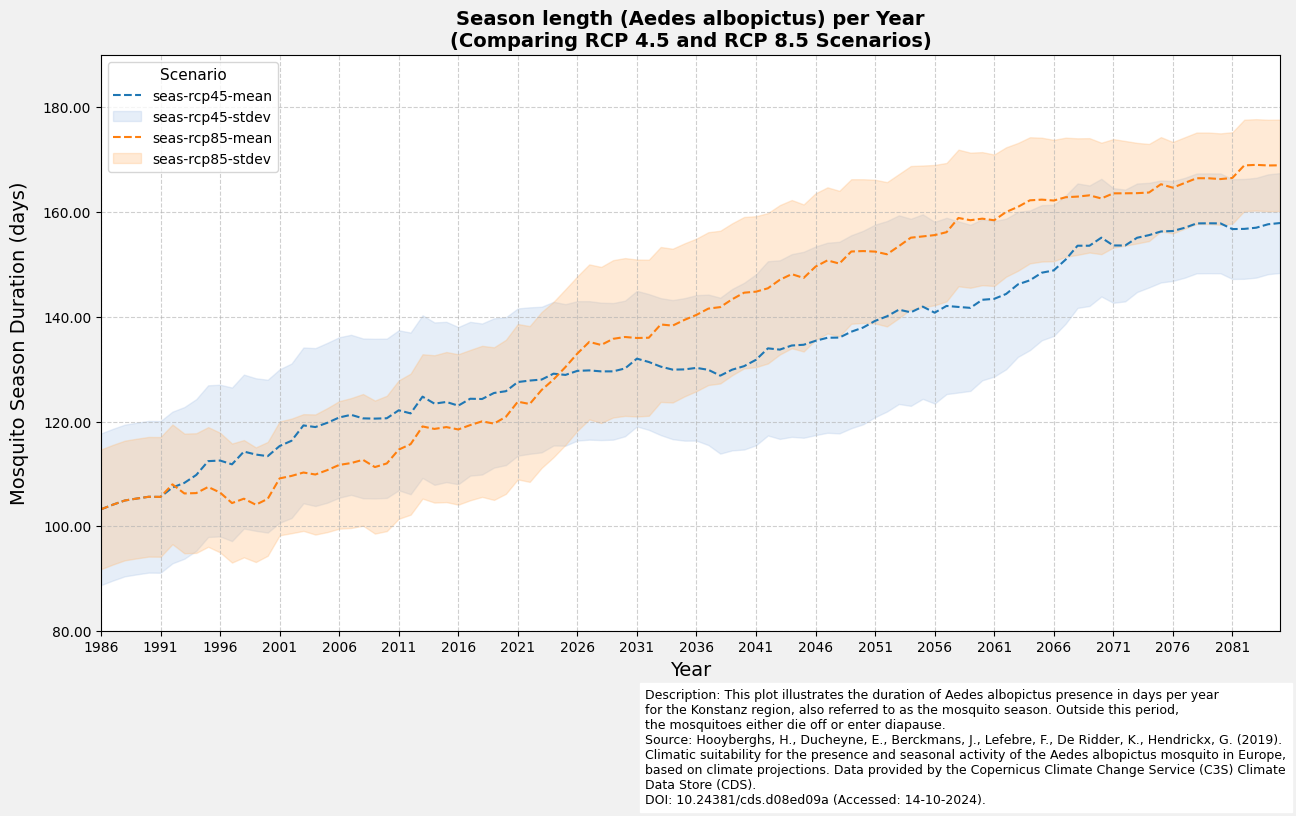

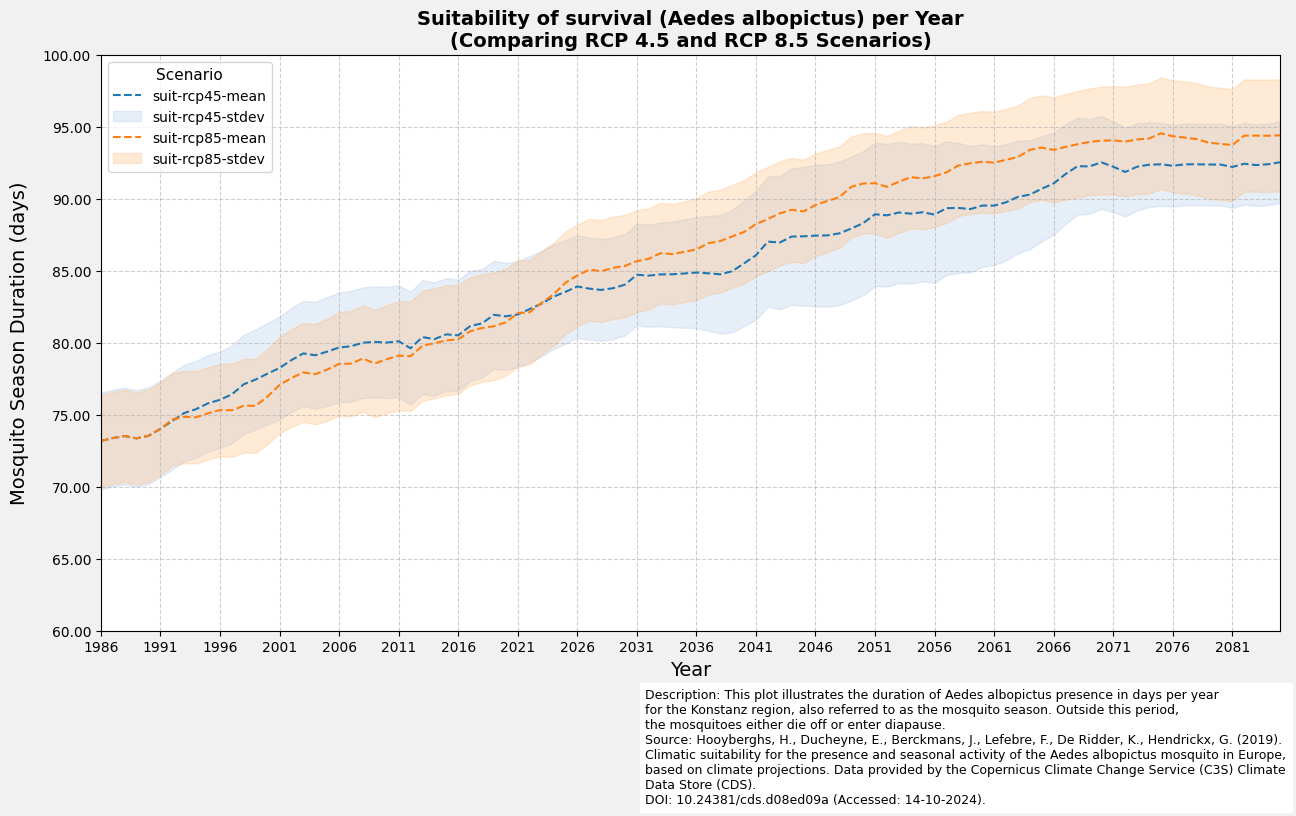

In [19]:
if __name__ == "__main__":
    plot_mosquito_season(filtered_df_average=filtered_df_average,
                         variable_name='seas')
    
    plot_mosquito_season(filtered_df_average=filtered_df_average,
                         variable_name='suit')